# Model Exploration
In this notebook, we want to explore different models and their performances:

1. **Load and preprocess data**:
    - Load credit applications and customer data.
    - Merge datasets and create features.
    - Perform minor cleaning and split data into train and test sets based on time.

2. **Feature selection and engineering**:
    - Define various feature groups and combinations.
    - Explore feature sets using Logistic Regression with grid search for hyperparameter tuning.

3. **Model exploration**:
    - Compare different feature sets using Logistic Regression.
    - Evaluate models based on F1 score and visualize ROC curves.

4. **Model training and evaluation**:
    - Train and evaluate Random Forest and LightGBM models using the best feature combination.
    - Perform grid search for hyperparameter tuning.
    - Evaluate models using confusion matrix and classification report.
    - Visualize ROC curves for the best models.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_dark"

from src.models import BaseModel, LogisticRegressionModel, RandomForestModel
from src.processing import IQRClipper, load_csv_data, merge_data
from src.features import create_features
from src.constants import AggregatedFeatures, RawFeatures
from src.model_visualizations import plot_roc_curve, plot_roc_curves, plot_shap_importance

/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/flight_delay_prediction_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
DEBUG = False
if not DEBUG:
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore')


## Load the merged dataset and create features

In [4]:
df_merged_flights = load_csv_data("../dataset/flights_with_features.csv")

# create features
# df_merged_features = create_features(df_merged)

In [5]:
df_merged_flights.columns

Index(['aircraftRegistration', 'aircraftType.iatamain', 'aircraftType.iatasub',
       'airlineCode', 'baggageClaim', 'estimatedLandingTime',
       'expectedTimeBoarding', 'expectedTimeGateClosing',
       'expectedTimeGateOpen', 'expectedTimeOnBelt', 'flightDirection',
       'flightName', 'flightNumber', 'gate', 'id', 'mainFlight', 'prefixIATA',
       'prefixICAO', 'publicEstimatedOffBlockTime',
       'publicFlightState.flightStates', 'route.destinations', 'scheduleDate',
       'scheduleTime', 'serviceType', 'terminal', 'transferPositions',
       'transferPositions.transferPositions', 'scheduledDeparture',
       'delay_minutes', 'delay_minutes_log', 'num_destinations',
       'first_destination', 'Airport', 'Name', 'City', 'Country', 'IATA',
       'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz',
       'Type', 'Source', 'region', 'log_delay', 'hour', 'day_of_week',
       'delay_previous_hour', 'delay_previous_day', 'agg_avg_delay_overall',
       'agg_cou

### Minor Cleaning and train/test split

In [6]:
# Assume X contains features and y contains labels
# Initial train/test split (e.g., 80% train, 20% test)
import pandas as pd

# Ensure the merged DataFrame (df_merged) is sorted by scheduledDeparture
df_merged = df_merged_flights.sort_values('scheduledDeparture')

# Define the split ratio (e.g., 80% train, 20% test)
train_frac = 0.80

# Get the total number of rows
n = len(df_merged)

# Compute the index where training ends
train_end = int(train_frac * n)

# Split the DataFrame
train_df = df_merged.iloc[:train_end].copy()
test_df = df_merged.iloc[train_end:].copy()

# Print out the date ranges for verification
print("Training period: {} to {}".format(train_df['scheduledDeparture'].min(), train_df['scheduledDeparture'].max()))
print("Testing period: {} to {}".format(test_df['scheduledDeparture'].min(), test_df['scheduledDeparture'].max()))

Training period: 2017-12-31 15:00:00+01:00 to 2018-03-08 17:05:00+01:00
Testing period: 2018-03-08 17:05:00+01:00 to 2018-03-25 00:55:00+01:00


### Get features

In [7]:
TARGET = RawFeatures._DELAY_TARGET

## Model exploration with grid search for hyperparameter and feature selection

### Feature search on Logistic Regression

In [8]:
features = [
    AggregatedFeatures.AGG_AVG_DELAY_OVERALL,
    AggregatedFeatures.AGG_COUNT_OVERALL,
    AggregatedFeatures.AGG_AVG_DELAY_TERMINAL,
    AggregatedFeatures.AGG_COUNT_TERMINAL,
    AggregatedFeatures.AGG_AVG_DELAY_REGION,
    AggregatedFeatures.AGG_COUNT_REGION,
    RawFeatures.DELAY_PREVIOUS_DAY,
]

In [9]:
groups = {
    "lag1": lag1_features,
    "lag2": lag2_features,
    "roll2": rolling_avg2_features,
    "roll4": rolling_avg4_features,
    "cum": cumulative_features,
    "crg": crg_feature
}

feature_combinations = {}
for r in range(1, min(4, len(groups) + 1)):  # max 2 combinations
    for combo in itertools.combinations(groups.keys(), r):
        name = f"{r}g_" + "+".join(combo)  # prefix with group count
        features = [f for group in combo for f in groups[group]]
        feature_combinations[name] = features

# Print summary
for name, features in feature_combinations.items():
    print(f"{name}: {[f.value for f in features]}")

1g_lag1: ['balance_range_lag1', 'min_balance_lag1', 'net_volume_lag1', 'debit_total_trx_ratio_lag1', 'debit_total_vol_ratio_lag1']
1g_lag2: ['balance_range_lag2', 'min_balance_lag2', 'net_volume_lag2', 'debit_total_trx_ratio_lag2', 'debit_total_vol_ratio_lag2']
1g_roll2: ['net_volume_rolling2', 'balance_range_rolling2', 'debit_total_trx_ratio_rolling2', 'debit_total_vol_ratio_rolling2']
1g_roll4: ['net_volume_rolling4', 'balance_range_rolling4', 'debit_total_trx_ratio_rolling4', 'debit_total_vol_ratio_rolling4']
1g_cum: ['cumulative_applications', 'cumulative_nr_applications']
1g_crg: ['CRG']
2g_lag1+lag2: ['balance_range_lag1', 'min_balance_lag1', 'net_volume_lag1', 'debit_total_trx_ratio_lag1', 'debit_total_vol_ratio_lag1', 'balance_range_lag2', 'min_balance_lag2', 'net_volume_lag2', 'debit_total_trx_ratio_lag2', 'debit_total_vol_ratio_lag2']
2g_lag1+roll2: ['balance_range_lag1', 'min_balance_lag1', 'net_volume_lag1', 'debit_total_trx_ratio_lag1', 'debit_total_vol_ratio_lag1', 'net_v

Features_1g_lag1: F1 Score = 0.180
Features_1g_lag2: F1 Score = 0.183
Features_1g_roll2: F1 Score = 0.144
Features_1g_roll4: F1 Score = 0.147
Features_1g_cum: F1 Score = nan
Features_1g_crg: F1 Score = 0.194
Features_2g_lag1+lag2: F1 Score = 0.183
Features_2g_lag1+roll2: F1 Score = 0.181
Features_2g_lag1+roll4: F1 Score = 0.178
Features_2g_lag1+cum: F1 Score = 0.202
Features_2g_lag1+crg: F1 Score = 0.196
Features_2g_lag2+roll2: F1 Score = 0.181
Features_2g_lag2+roll4: F1 Score = 0.182
Features_2g_lag2+cum: F1 Score = 0.202
Features_2g_lag2+crg: F1 Score = 0.197
Features_2g_roll2+roll4: F1 Score = 0.142
Features_2g_roll2+cum: F1 Score = 0.188
Features_2g_roll2+crg: F1 Score = 0.191
Features_2g_roll4+cum: F1 Score = 0.189
Features_2g_roll4+crg: F1 Score = 0.193
Features_2g_cum+crg: F1 Score = 0.206
Features_3g_lag1+lag2+roll2: F1 Score = 0.186
Features_3g_lag1+lag2+roll4: F1 Score = 0.179
Features_3g_lag1+lag2+cum: F1 Score = 0.203
Features_3g_lag1+lag2+crg: F1 Score = 0.201
Features_3g_

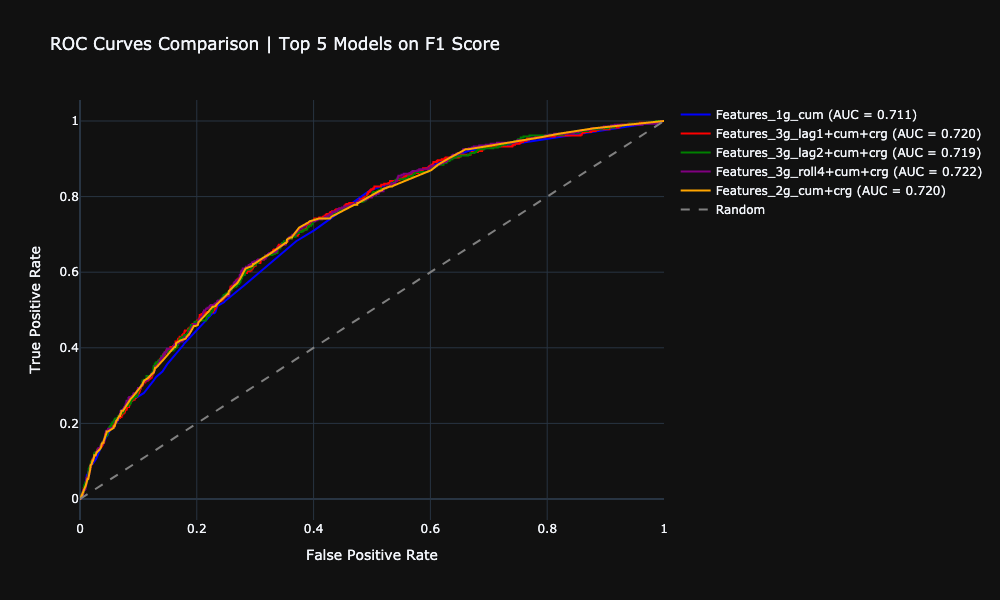

In [10]:
def run_grid_search(X_train, y_train, features, param_grid, cv):
    base_model = BaseModel()
    lr_model = ("lr", LogisticRegression(class_weight="balanced", max_iter=10000))
    pipeline = base_model.create_pipeline(model_step=lr_model)
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )
    
    X_train_subset = X_train[features]
    grid_search.fit(X_train_subset, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_,

def compare_feature_sets(df_train, df_test, feature_combinations, param_grid):
    cv = TimeSeriesSplit(n_splits=3)
    results = []
    
    for feature_kind, features_selected in feature_combinations.items():
        X_train = df_train[features_selected]
        y_train = df_train[TARGET]
        X_test  = df_test[features_selected]
        y_test  = df_test[TARGET]
        
        best_model, best_score, best_params = run_grid_search(X_train, y_train, features_selected, param_grid, cv)
        results.append({
            "name": f"Features_{feature_kind}",
            "score": best_score,
            "predictions": best_model.predict_proba(X_test),
            "predicted_labels": best_model.predict(X_test),
            "features": features_selected,
            "best_params": best_params,
        })
        print(f"Features_{feature_kind}: F1 Score = {best_score:.3f}")
    
    # Sort by score and take top 5
    top_5_models = sorted(results, key=lambda x: x["score"], reverse=True)[:5]
    
    # Create predictions dict for top models
    model_predictions = {
        model["name"]: model["predictions"] 
        for model in top_5_models
    }
    
    # Plot the confusion matrix and print params, features for the best model out of the top 5
    best_model = top_5_models[0]
    print("Best Model Parameters:", best_model["best_params"])
    print("Best Model Features:", [f.value for f in best_model["features"]])
    # Confusion Matrix
    cm = confusion_matrix(y_test, best_model["predicted_labels"])
    cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print("=== Confusion Matrix (Test) ===")
    print(cm_df)
    print("=== Classification Report (Test) ===")
    print(classification_report(y_test, best_model["predicted_labels"], digits=3))
    
    return plot_roc_curves(y_test, model_predictions, title="ROC Curves Comparison | Top 5 Models on F1 Score") 

# Usage
param_grid_lr = {
    "outlier_clip__factor": [7, 10.0, 15],
    "lr__C": [0.01, 0.1, 1, 10]
}

fig = compare_feature_sets(
    df_train, df_test,
    feature_combinations=feature_combinations,
    param_grid=param_grid_lr
)
fig.show()

### Best feature combination

In [9]:
features_selected = features
X_train = train_df[features_selected]
y_train = train_df[TARGET]
X_test  = test_df[features_selected]
y_test  = test_df[TARGET]

class_0_count = (y_train == 0).sum()
class_1_count = (y_train == 1).sum()
class_imabalance_weight = class_0_count / class_1_count

## Trying different models with the best feature combination

In [10]:
base_model = BaseModel()
rf_model =("rf", RandomForestClassifier(
                                            class_weight="balanced",
                                            n_estimators=100,
                                            random_state=42
                                        ))
rf_pipeline = base_model.create_pipeline(model_step=rf_model)

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    "outlier_clip__factor": [5.0, 10.0, 12],
    "rf__max_depth": [None, 5, 10, 20],
    "rf__n_estimators": [50, 100, 200]
}

grid_search_rf= GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    scoring="f1", #"precision",  # or "average_precision", "recall", etc. for imbalance
    cv=tscv,
    n_jobs=-1
)

# Fit on the training set
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('outlier_clip', IQRClipper(factor=7.0)),
                                       ('scaler', StandardScaler()),
                                       ('var_thresh', VarianceThreshold()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'outlier_clip__factor': [5.0, 10.0, 12],
                         'rf__max_depth': [None, 5, 10, 20],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='f1')

Random Forest Best params: {'outlier_clip__factor': 5.0, 'rf__max_depth': 5, 'rf__n_estimators': 50}
Random Forest Best score: 0.6938625065905715
=== Random Forest  Confusion Matrix (Test) ===
                 Predicted Negative  Predicted Positive
Actual Negative               20554                4601
Actual Positive                4531                9053
=== Random Forest Classification Report (Test) ===
              precision    recall  f1-score   support

           0      0.819     0.817     0.818     25155
           1      0.663     0.666     0.665     13584

    accuracy                          0.764     38739
   macro avg      0.741     0.742     0.741     38739
weighted avg      0.765     0.764     0.764     38739



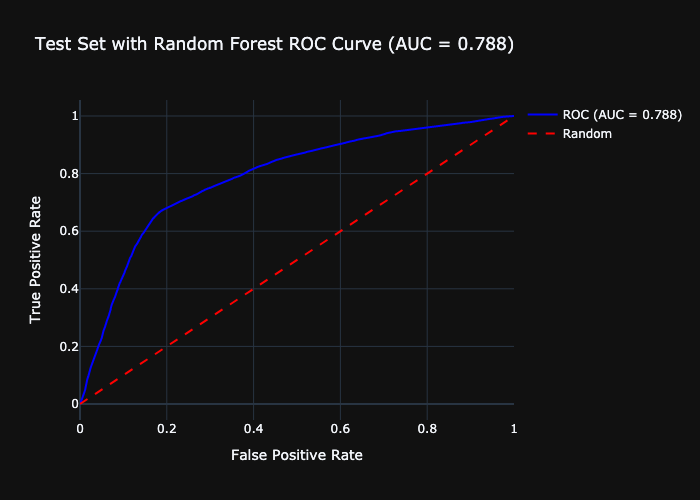

In [11]:
best_pipeline = grid_search_rf.best_estimator_
print("Random Forest Best params:", grid_search_rf.best_params_)
print("Random Forest Best score:", grid_search_rf.best_score_)


y_pred_test = best_pipeline.predict(X_test)
print("=== Random Forest  Confusion Matrix (Test) ===")
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(cm_df)
print("=== Random Forest Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=3))

best_model = grid_search_rf.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)
fig = plot_roc_curve(y_test, y_pred_proba, "Test Set with Random Forest ")
fig.show()

### Understand correct threshold

In [12]:
from src.constants import RANDOM_FOREST_PARAMS
from src.models import RandomForestModel

# Fit the model
rf_best_pipeline = RandomForestModel(model_arguments=RANDOM_FOREST_PARAMS).get_pipeline()
rf_best_pipeline.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = rf_best_pipeline.predict_proba(X_test)[:, 1]

# Define thresholds
thresholds = [0.2, 0.3, 0.4, 0.5]

# Evaluate for each threshold
for threshold in thresholds:
    y_pred_test = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print(f"=== Confusion Matrix (Test) for threshold {threshold} ===")
    print(cm_df)
    print(f"=== Classification Report (Test) for threshold {threshold} ===")
    print(classification_report(y_test, y_pred_test, digits=3))

=== Confusion Matrix (Test) for threshold 0.2 ===
                 Predicted Negative  Predicted Positive
Actual Negative                1770               23385
Actual Positive                 199               13385
=== Classification Report (Test) for threshold 0.2 ===
              precision    recall  f1-score   support

           0      0.899     0.070     0.131     25155
           1      0.364     0.985     0.532     13584

    accuracy                          0.391     38739
   macro avg      0.631     0.528     0.331     38739
weighted avg      0.711     0.391     0.271     38739

=== Confusion Matrix (Test) for threshold 0.3 ===
                 Predicted Negative  Predicted Positive
Actual Negative               13948               11207
Actual Positive                2125               11459
=== Classification Report (Test) for threshold 0.3 ===
              precision    recall  f1-score   support

           0      0.868     0.554     0.677     25155
           1      

In [26]:
def analyze_false_negatives(pipeline, df, X_test, y_test, threshold=0.4):
    # Get predictions
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Find false negatives (actual=1, predicted=0)
    false_neg_mask = (y_test == 1) & (y_pred == 0)
    false_neg_indices = y_test[false_neg_mask].index
    
    # Create analysis dataframe with relevant columns
    analysis_df = pd.DataFrame({
        'predicted_probability': y_pred_proba[false_neg_mask],
        # 'agg_avg_delay_overall': df.loc[false_neg_indices, 'agg_avg_delay_overall'],
        # 'agg_avg_delay_terminal': df.loc[false_neg_indices, 'agg_avg_delay_terminal'],
        # 'agg_avg_delay_region': df.loc[false_neg_indices, 'agg_avg_delay_region'],
        # 'agg_count_terminal': df.loc[false_neg_indices, 'agg_count_terminal'],
        'region': df.loc[false_neg_indices, 'region'],
        # 'delay_previous_day': df.loc[false_neg_indices, 'delay_previous_day']
    }).sort_values('predicted_probability', ascending=True)

    
    print(f"Total False Negatives: {len(analysis_df)}")
    print("\nFalse Negative Analysis:")
    print(analysis_df.describe().round(2))
    
    return analysis_df




false_neg_df = analyze_false_negatives(
    rf_best_pipeline,
    df_merged,
    X_test,
    y_test,
    threshold=0.4
)

ValueError: array length 4111 does not match index length 19916

In [24]:
df_merged.columns

Index(['aircraftRegistration', 'aircraftType.iatamain', 'aircraftType.iatasub',
       'airlineCode', 'baggageClaim', 'estimatedLandingTime',
       'expectedTimeBoarding', 'expectedTimeGateClosing',
       'expectedTimeGateOpen', 'expectedTimeOnBelt', 'flightDirection',
       'flightName', 'flightNumber', 'gate', 'id', 'mainFlight', 'prefixIATA',
       'prefixICAO', 'publicEstimatedOffBlockTime',
       'publicFlightState.flightStates', 'route.destinations', 'scheduleDate',
       'scheduleTime', 'serviceType', 'terminal', 'transferPositions',
       'transferPositions.transferPositions', 'scheduledDeparture',
       'delay_minutes', 'delay_minutes_log', 'num_destinations',
       'first_destination', 'Airport', 'Name', 'City', 'Country', 'IATA',
       'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz',
       'Type', 'Source', 'region', 'log_delay', 'hour', 'day_of_week',
       'delay_previous_hour', 'delay_previous_day', 'agg_avg_delay_overall',
       'agg_cou

In [15]:
application_summary = (
    false_neg_df
    .groupby('previous_nr_applications')
    .agg({
        'client_nr': 'count',
        'predicted_probability': ['mean', 'std']
    })
    .reset_index()
)

application_summary.columns = ['nr_previous_applications', 'count', 'mean_probability', 'std_probability']
application_summary['percentage'] = (application_summary['count'] / len(false_neg_df) * 100).round(2)
application_summary = application_summary.sort_values('nr_previous_applications')

print("Distribution of Previous Applications in False Negatives:")
print(application_summary.to_string(index=False))

Distribution of Previous Applications in False Negatives:
 nr_previous_applications  count  mean_probability  std_probability  percentage
                      0.0     27          0.302332         0.089563       93.10
                      1.0      1          0.336855              NaN        3.45
                      2.0      1          0.382127              NaN        3.45


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000))
])

param_grid = {
    "lr__C": [0.1, 1, 10, 100],
    "lr__penalty": ["l1", "l2"],
    "lr__solver": ["liblinear"]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'lr__C': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best score: 0.6779345074652963


Random Forest Best params: {'lr__C': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Random Forest Best score: 0.6779345074652963
=== Random Forest  Confusion Matrix (Test) ===
                 Predicted Negative  Predicted Positive
Actual Negative               24188                 967
Actual Positive               12498                1086
=== Random Forest Classification Report (Test) ===
              precision    recall  f1-score   support

           0      0.659     0.962     0.782     25155
           1      0.529     0.080     0.139     13584

    accuracy                          0.652     38739
   macro avg      0.594     0.521     0.461     38739
weighted avg      0.614     0.652     0.557     38739



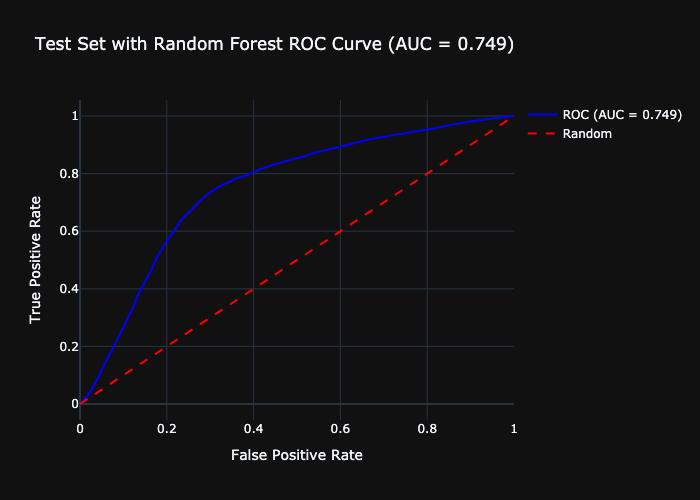

In [31]:
best_pipeline = grid_search.best_estimator_
print("Random Forest Best params:", grid_search.best_params_)
print("Random Forest Best score:", grid_search.best_score_)


y_pred_test = best_pipeline.predict(X_test)
print("=== Random Forest  Confusion Matrix (Test) ===")
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(cm_df)
print("=== Random Forest Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=3))

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)
fig = plot_roc_curve(y_test, y_pred_proba, "Test Set with Random Forest ")
fig.show()

In [32]:
from lightgbm import LGBMClassifier
base_model = BaseModel()
lgbm_model = ("lgbm", LGBMClassifier(scale_pos_weight=class_imabalance_weight, random_state=42))
lgbm_pipeline = base_model.create_pipeline(model_step=lgbm_model)

tscv = TimeSeriesSplit(n_splits=3)

param_grid_lgbm = {
    "outlier_clip__factor": [5, 12],            # try different outlier thresholds# how many features to keep
    "lgbm__n_estimators": [50, 100, 200],  # Number of boosting rounds
    "lgbm__max_depth": [-1, 5, 10],  # Tree depth (-1 means unlimited)
    "lgbm__learning_rate": [0.005],  # Learning rate
    "lgbm__scale_pos_weight": [class_imabalance_weight, class_imabalance_weight*1.5],
    "lgbm__pos_bagging_fraction": [0.5, 0.7, 1.0],  # Fraction of positive samples in bagging
    "lgbm__neg_bagging_fraction": [0.1],  # Overall dataset fraction for subsampling
    "lgbm__bagging_freq": [1, 2],  # How often bagging is performed (1 = every boosting round)
    "lgbm__verbosity": [-1],
}

grid_search_lgbm = GridSearchCV(
    lgbm_pipeline,
    param_grid=param_grid_lgbm,
    scoring="f1",
    cv=tscv,
    n_jobs=-1
)
grid_search_lgbm.fit(X_train, y_train)

/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/flight_delay_prediction_project/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/flight_delay_prediction_project/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `skle

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('outlier_clip', IQRClipper(factor=7.0)),
                                       ('scaler', StandardScaler()),
                                       ('var_thresh', VarianceThreshold()),
                                       ('lgbm',
                                        LGBMClassifier(random_state=42,
                                                       scale_pos_weight=1.7413710747456876))]),
             n_jobs=-1,
             param_grid={'lgbm__bagging_freq': [1, 2],
                         'lgbm__learning_rate': [0.005],
                         'lgbm__max_depth': [-1, 5, 10],
                         'lgbm__n_estimators': [50, 100, 200],
                         'lgbm__neg_bagging_fraction': [0.1],
                         'lgbm__pos_bagging_fraction': [0.5, 0.7, 1.0],
                         'lgbm__scale_pos_weight': [1.7413710747456876,
                                                    2.6120566121185314],
                         'lgbm__verbosity': [-1],
                         'outlier_clip__factor': [5, 12]},
             scoring='f1')

LightGBM Best params: {'lgbm__bagging_freq': 2, 'lgbm__learning_rate': 0.005, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 100, 'lgbm__neg_bagging_fraction': 0.1, 'lgbm__pos_bagging_fraction': 0.5, 'lgbm__scale_pos_weight': 1.7413710747456876, 'lgbm__verbosity': -1, 'outlier_clip__factor': 5}
LightGBM Best score: 0.6811864516858045
=== LightGBM Confusion Matrix (Test) ===
                 Predicted Negative  Predicted Positive
Actual Negative               16348                8807
Actual Positive                2908               10676
=== LightGBM Classification Report (Test) ===
              precision    recall  f1-score   support

           0      0.849     0.650     0.736     25155
           1      0.548     0.786     0.646     13584

    accuracy                          0.698     38739
   macro avg      0.698     0.718     0.691     38739
weighted avg      0.743     0.698     0.704     38739



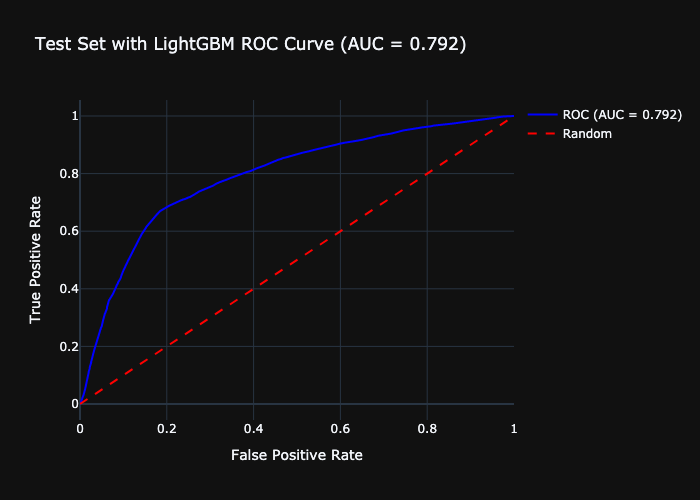

In [33]:
best_pipeline = grid_search_lgbm.best_estimator_
print("LightGBM Best params:", grid_search_lgbm.best_params_)
print("LightGBM Best score:", grid_search_lgbm.best_score_)


y_pred_test = best_pipeline.predict(X_test)
print("=== LightGBM Confusion Matrix (Test) ===")
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(cm_df)
print("=== LightGBM Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=3))

best_model = grid_search_lgbm.best_estimator_
y_pred_proba2 = best_model.predict_proba(X_test)
fig = plot_roc_curve(y_test, y_pred_proba2, "Test Set with LightGBM ")
fig.show()

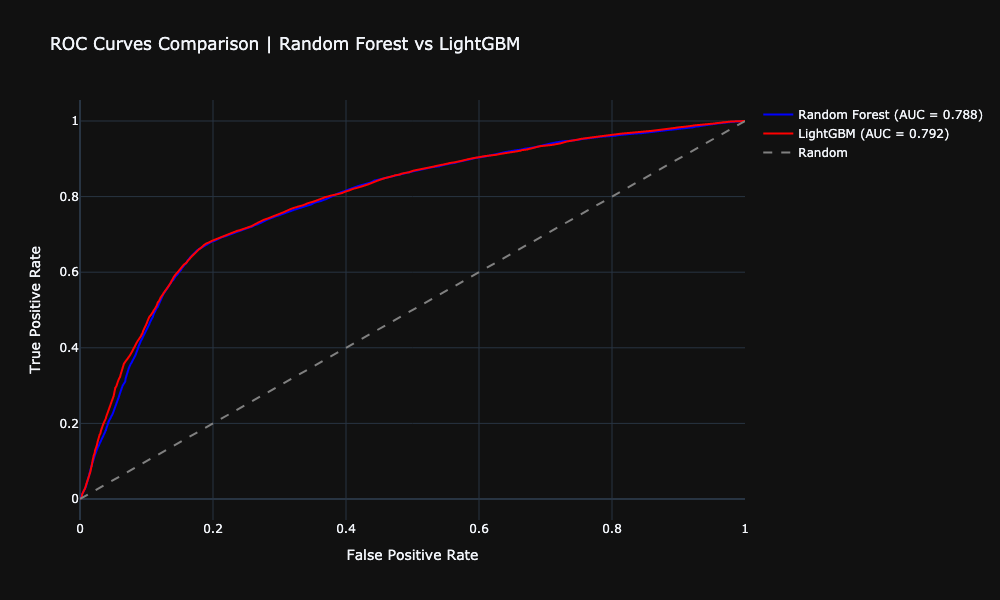

In [34]:
both_predictions = {
    "Random Forest": rf_best_pipeline.predict_proba(X_test),
    "LightGBM": y_pred_proba2
}
plot_roc_curves(y_test, both_predictions, title="ROC Curves Comparison | Random Forest vs LightGBM")

[###] Optional - Investigate shap values for features

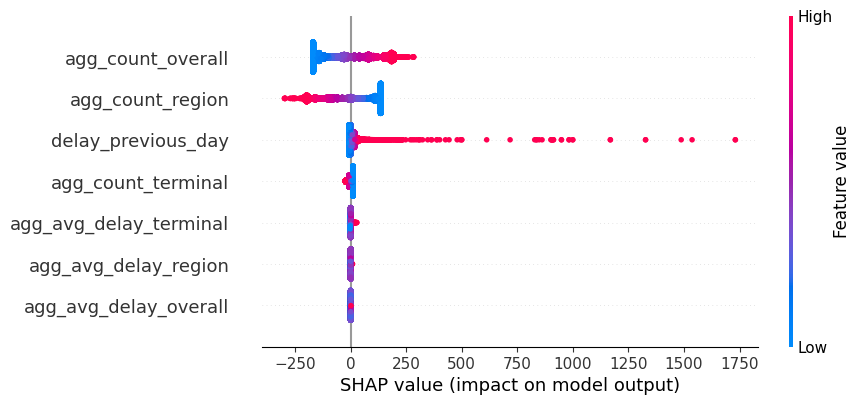

<Figure size 640x480 with 0 Axes>

In [35]:
X_test_subset = test_df[features_selected]
model_arguments = {"C": 0.01, "class_weight": "balanced", "max_iter": 10000}
lr_pipeline = LogisticRegressionModel(model_arguments=model_arguments).get_pipeline()
lr_pipeline.fit(X_train, y_train)
shap_fig = plot_shap_importance(
    pipeline=lr_pipeline, 
    X=X_test_subset, 
    feature_names=[f.value for f in features_selected]
    )
shap_fig.show()